In [88]:
import json
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1

# Face feature extractor

In [89]:
def clahe_hsv(img, clipLimit=2.0, tileGridSize=(5, 5)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(v)

    hsv_clahe = cv2.merge((h, s, cl))

    final = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2BGR)
    return final




In [90]:
def image_preprocessing(img, clipLimit=2, tileGridSize=(8, 8)):
    img = cv2.resize(img, (160, 160))
    clahe = clahe_hsv(img, clipLimit, tileGridSize)

    blur = cv2.bilateralFilter(clahe, 7, 60, 60)

    kernel = np.array([[0, -1, 0],
                       [-1, 4.8, -1],
                       [0, -1, 0]])

    final = cv2.filter2D(blur, -1, kernel)
    final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    return final

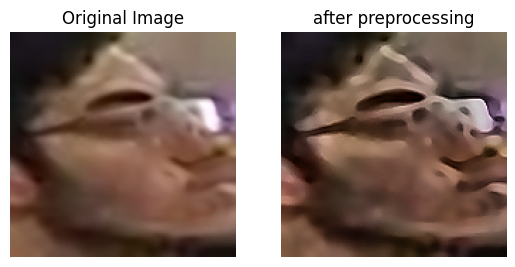

In [91]:
img = cv2.imread("data_extract/processed_faces/face_1958.jpg")
result = image_preprocessing(img, clipLimit=2, tileGridSize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('after preprocessing')
plt.axis('off')

plt.show()

In [92]:
from face_detection import RetinaFace

detector = RetinaFace(gpu_id=-1)

img = cv2.imread("data_extract/processed_faces/face_1166.jpg")
detector(img)

[(array([ 26.200775,  15.393872, 150.01945 , 134.86555 ], dtype=float32),
  array([[ 85.150314,  46.299557],
         [135.93092 ,  28.331709],
         [139.68927 ,  64.7758  ],
         [111.59766 , 102.53602 ],
         [150.00151 ,  88.60126 ]], dtype=float32),
  0.365803),
 (array([ 71.27661  ,   5.4936194, 145.8096   ,  78.938156 ], dtype=float32),
  array([[106.66638 ,  23.784485],
         [135.55586 ,  17.031887],
         [139.94641 ,  33.808167],
         [121.78781 ,  58.291187],
         [143.77795 ,  53.167076]], dtype=float32),
  0.03248457)]

In [95]:
def extract_embeddings(face_metadata):
    print("Extracting embeddings...")

    model = InceptionResnetV1(pretrained='vggface2').eval()
    embeddings = []
    valid_metadata = []
    face_indices = {}
    for data in tqdm(face_metadata, desc="Extracting embeddings"):
        data['filename'] = data['filename'].replace("temp_faces", "processed_faces")
        try:
            face_img = cv2.imread(data['filename'])

            if face_img is None:
                continue
            face_img = face_img.astype(np.float32) / 255.0
            face_img = np.transpose(face_img, (2, 0, 1))
            face_img = torch.tensor(face_img).unsqueeze(0)

            with torch.no_grad():
                embedding = model(face_img)

            embeddings.append(embedding.numpy().flatten())
            valid_metadata.append(data)
            face_indices[data['filename']] = len(embeddings)
        except Exception as e:
            print(f"Error while extracting embeddings: {e}")

    return np.array(embeddings), valid_metadata, face_indices

In [96]:
face_metadata = json.load(open("data_extract/face_metadata.json", "r", encoding="utf-8"))
face_embeddings, face_metadata, face_index = extract_embeddings(face_metadata)

Extracting embeddings...


Extracting embeddings: 100%|██████████| 6213/6213 [04:53<00:00, 21.19it/s]


# clutser face feature

In [110]:
import os
import shutil
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity

GROUPED_FACES_DIR = 'data_extract/temp_grouped_faces'
REFINEMENT_THRESHOLD = 0.8


def cluster_and_refine_faces(embeddings, valid_metadata):
    # --- Step 1: Initial clustering ---
    clusterer = HDBSCAN(
        min_cluster_size=8,  # Minimum members to form a cluster
        metric='cosine',  # Use cosine similarity
        cluster_selection_epsilon=0.155,  # Merge close clusters
    ).fit(embeddings)

    labels = clusterer.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    print(f"1. Initial clustering: {n_clusters} clusters and {n_noise} noise points found.")

    # --- Step 2: Cluster refinement ---
    print("\n2. Starting cluster refinement...")

    centroids = {}
    for cluster_id in set(labels):
        if cluster_id != -1:
            cluster_embeddings = embeddings[labels == cluster_id]
            centroids[cluster_id] = np.mean(cluster_embeddings, axis=0)

    final_labels = np.copy(labels)
    reassigned_count = 0

    noise_indices = np.where(labels == -1)[0]
    for i in noise_indices:
        embedding = embeddings[i]
        best_sim = -1
        best_cluster = -1

        for cluster_id, centroid in centroids.items():
            sim = cosine_similarity(
                embedding.reshape(1, -1),
                centroid.reshape(1, -1)
            )[0][0]

            if sim > best_sim:
                best_sim = sim
                best_cluster = cluster_id

        if best_sim > REFINEMENT_THRESHOLD:
            final_labels[i] = best_cluster
            reassigned_count += 1

    print(f"{reassigned_count} noise points reassigned to existing clusters.")

    # --- Step 3: Save results ---
    print("\n3. Saving results...")
    if os.path.exists(GROUPED_FACES_DIR):
        shutil.rmtree(GROUPED_FACES_DIR)
    os.makedirs(GROUPED_FACES_DIR)

    for i, label in enumerate(final_labels):
        if label == -1:
            group_dir = os.path.join(GROUPED_FACES_DIR, 'noise')
        else:
            group_dir = os.path.join(GROUPED_FACES_DIR, f'person_{label}')

        os.makedirs(group_dir, exist_ok=True)
        src_path = valid_metadata[i]['filename']
        dst_filename = os.path.basename(src_path)
        dst_path = os.path.join(group_dir, dst_filename)
        shutil.copy2(src_path, dst_path)

    print(f"✅ Final clustering done. Results saved in '{GROUPED_FACES_DIR}'.")
    return final_labels


In [111]:
final_cluster_labels = cluster_and_refine_faces(face_embeddings, face_metadata)


1. Initial clustering: 30 clusters and 4071 noise points found.

2. Starting cluster refinement...
208 noise points reassigned to existing clusters.

3. Saving results...
✅ Final clustering done. Results saved in 'data_extract/temp_grouped_faces'.


In [113]:
directory = os.listdir('data_extract/temp_grouped_faces')
# os.mkdir('data_extract/final_grouped_faces/noise')
for d in directory:
    if d.startswith('person_'):
        shutil.copytree(
            f'data_extract/temp_grouped_faces/{d}',
            f'data_extract/final_grouped_faces/{d}',
            dirs_exist_ok=True  # only in Python 3.8+
        )

# DataBase

In [130]:
def compute_weighted_medoid_choice(embeddings):
    sim_matrix = cosine_similarity(embeddings)

    # Compute weights as the sum of similarities for each embedding
    weights = sim_matrix.sum(axis=1)

    # Normalize weights
    weights = weights / weights.sum()

    # Compute weighted average embedding
    weighted_medoid = np.average(embeddings, axis=0, weights=weights)

    return weighted_medoid


main_folder = "data_extract/final_grouped_faces"

medoids = {}

for folder_name in tqdm(os.listdir(main_folder), 'process:'):
    if folder_name.startswith("person_") and os.path.isdir(os.path.join(main_folder, folder_name)):
        folder_path = os.path.join(main_folder, folder_name)
        embeddings = []

        for img_name in os.listdir(folder_path):
            img_index = int(img_name.split("_")[1].split(".")[0])
            img_path = os.path.join(folder_path, img_name)
            embeddings.append(face_embeddings[img_index])

        embeddings = np.array(embeddings)
        if len(embeddings) > 0:
            medoid = compute_weighted_medoid_choice(embeddings)
            medoids[folder_name] = medoid

print("Medoids computed for each folder")
torch.save(medoids, "data_extract/person_medoids.pt")


process:: 100%|██████████| 26/26 [00:00<00:00, 984.71it/s]

Medoids computed for each folder


In [128]:
# Load medoids
medoids = torch.load("data_extract/person_medoids.pt")
import torch.nn.functional as F

# New sample


# Compute cosine similarity
best_person = None
best_score = -1
for person, medoid in medoids.items():
    score = F.cosine_similarity(torch.tensor(new_embedding), torch.tensor(medoid), dim=0)
    if score > best_score:
        best_score = score
        best_person = person

print(f"This sample belongs to: {best_person}, similarity: {best_score.item()}")


This sample belongs to: person_20, similarity: 0.8637816905975342


In [126]:
a = np.zeros(shape=(len(medoids), len(medoids)))
i, j = 0, 0
new_embedding = face_embeddings[5428]
for person, medoid in medoids.items():
    for p, m in medoids.items():
        score = F.cosine_similarity(torch.tensor(m), torch.tensor(medoid), dim=0)
        a[i, j] = score
        j += 1
    j=0
    i += 1
a

array([[ 1.00000000e+00,  2.19910935e-01,  3.00398558e-01,
         4.08834517e-01,  2.54446298e-01,  4.79762822e-01,
         4.59981114e-01,  1.90722004e-01,  2.08671302e-01,
         3.67833376e-01,  1.15429997e-01,  3.22153270e-01,
         5.59442163e-01,  4.46233869e-01,  3.39820176e-01,
         3.81875396e-01,  2.41835833e-01,  1.63882241e-01,
         8.81977603e-02,  4.86828297e-01,  2.27944896e-01,
         4.12983477e-01,  3.98126185e-01,  2.75446385e-01,
         5.72611511e-01,  3.08954239e-01],
       [ 2.19910935e-01,  9.99999940e-01,  3.41801465e-01,
         5.87224126e-01,  3.98321509e-01,  2.79710561e-01,
         2.44067580e-01,  3.64605993e-01,  4.65245128e-01,
         4.63787377e-01,  3.72110516e-01,  3.56124222e-01,
         2.32850343e-01,  3.04043144e-01,  3.41130614e-01,
         2.89353013e-01,  4.77699459e-01,  2.64412344e-01,
         2.67255455e-01,  4.81959015e-01,  4.25064325e-01,
         2.95263588e-01,  4.03793246e-01,  2.64455080e-01,
         2.32